read

In [14]:
#正常  -2839 
import os
#a12s='/home/lee11670064/data/a12s.csv'
import pandas as pd
import csv
from pydicom import dcmread
from pydicom.data import get_testdata_files
!pip install SimpleITK
import SimpleITK as sitk
import numpy as np
import cv2

# 開啟 CSV 檔案
a12s=pd.read_csv('/home/lee11670064/data/a12s.csv')


path_txts_3 = a12s['path']
if  os.path.isfile(file_path):
    for path_txt in path_txts_3:
        # 定義檔案路徑
        file_path = f'/my_part/mimic-cxr/file/{path_txt}'
        
        # 讀取 DICOM 檔案
        ds = dcmread(file_path)
        # 列出所有後設資料（metadata） -附帶的實驗相關資訊
        #print(ds)
       #  import matplotlib.pyplot as plt
        # 以 matplotlib 繪製影像
       #  plt.imshow(ds.pixel_array)
        # plt.show()

In [16]:


def convert_from_dicom_to_jpg(img,low_window,high_window,save_path):
  lungwin = np.array([low_window*1.,high_window*1.])
  newimg = (img-lungwin[0])/(lungwin[1]-lungwin[0])  #歸一化
  newimg = (newimg*255).astype('uint8')        #將像素值擴展到[0,255]
  cv2.imwrite(save_path, newimg, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

def split_image(src_path, rownum, colnum, file):
 img = cv2.imread(src_path)
 size = img.shape[0:2]
 w = size[1]
 h = size[0]
 row_height = h // rownum
 col_width = w // colnum
 print(file, w, h)
 # 每行的高度和每列的寬度
 num = 0
 for i in range(rownum):
      for j in range(colnum):
          # 儲存切割好的圖片的路徑
          # src_path.split('.')[0] + '_' + str((i+1)*(j+1)) + '.jpg'
        save_path = '/home/lee11670064/cnn_model/cut/' + file.split('.')[0] + '_' + str((i+1)+(rownum *j) ) + '.jpg'

        row_start = j * col_width
        row_end = (j+1) * col_width
        col_start = i * row_height
        col_end = (i+1) * row_height
        #print(rownum,colnum,row,col,save_path)
        #print(row_start, row_end, col_start, col_end)
        child_img = img[col_start:col_end, row_start:row_end]
        cv2.imwrite(save_path, child_img)    # cv2图片： [高， 宽]


# DICOM 檔案 轉換成 JPG + 圖片切割
if __name__ == '__main__':
    # 設定 DICOM 檔案的路徑
    dicom_file_path = '/home/lee11670064/cnn_model/1000.dcm'

    # 讀取 DICOM 檔案
    ds_array = sitk.ReadImage(dicom_file_path)
    # 獲取 DICOM 圖片的 array
    img_array = sitk.GetArrayFromImage(ds_array)
    # SimpleITK讀取的影像資料的座標順序為zyx，也就是從多少張切片到單張切片的寬和高，這裡我們讀取單張，因此img_array的shape 
    #類似於 （1，height，width）的形式
    shape = img_array.shape
    img_array = np.reshape(img_array, (shape[1], shape[2])) #取得array中的height和width
    high = np.max(img_array)
    low = np.min(img_array)
    # 轉換成 JPG 並保存到指定路徑
    output_jpg_path = '/home/lee11670064/cnn_model/JPG_image/lung001.jpg'
    convert_from_dicom_to_jpg(img_array, low, high, output_jpg_path)

    if __name__ == '__main__':
      # 繼續後續的圖片切割等操作
      src_path = output_jpg_path  # src_path 具體圖片路徑，包含後綴
      row = 10
      col = 10
      file_name = 'lung001.jpg' # 設置要處理的文件名
      split_image(src_path, row, col, file_name.split('.')[0])

lung001 2544 3056


In [17]:
import os
import cv2
import numpy as np

# 圖像資料夾路徑
fol = '/home/lee11670064/cnn_model/cut/'
# 讀取並處理影像
x_data = []

# 處理資料夾0中的影像
for filename in os.listdir(fol):
    img = cv2.imread(os.path.join(fol, filename))
    img = cv2.resize(img,(64, 64))  #調整圖像大小為模型輸入大小
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 轉換為灰階影像
    img = img / 255.0  # 歸一化像素值
    x_data.append(img)
# 將圖像資料轉換為NumPy數組
x_data = np.array(x_data)  
# 輸出 x_data 的形狀
print("x_data shape:", x_data.shape)

x_data shape: (100, 64, 64)


## Build a PyTorch CNN model

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Class2(nn.Module):
    def __init__(self):
        super(Class2, self).__init__()
        # 卷積層
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, \
                               stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, \
                               stride=1, padding=1)
        # 線性層
        self.linear1 = nn.Linear(in_features=65536, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=64)
        # 隨機失活(Dropout)
        self.dropout = nn.Dropout(p=0.25)
        self.linear3 = nn.Linear(in_features=64, out_features=2)

    def forward(self, image_batch):
        image_batch = F.relu(input=self.conv1(image_batch))
        image_batch = F.relu(input=self.conv2(image_batch))

        flat_image_batch = image_batch.view(image_batch.shape[0], -1)
        flat_image_batch = F.relu(input=self.linear1(flat_image_batch))
        flat_image_batch = self.dropout(F.relu(input=self.linear2(flat_image_batch)))
        probabilities = F.softmax(self.linear3(flat_image_batch), dim=1)  # 使用softmax轉換成機率
        #print("flat_image_batch shape:", flat_image_batch.shape)
        #print("linear1 output shape:", flat_image_batch.shape)
        return probabilities

## 檢查模型

In [19]:
model = Class2()
model

Class2(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=65536, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
)

In [20]:
from torchsummary import summary
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('The model will run on', device)
# Initialize 初始化模型
model= Class2().to(device)
print(model)
summary(model=model, input_size=(1, 64, 64), batch_size=16) # Summarize

The model will run on cpu
Class2(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=65536, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear3): Linear(in_features=64, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [16, 8, 64, 64]              80
            Conv2d-2           [16, 16, 64, 64]           1,168
            Linear-3                  [16, 256]      16,777,472
            Linear-4                   [16, 64]          16,448
           Dropout-5                   [16, 64]               0
            Linear-6                    [16, 2]             130
Total params: 16,795,298
Trainable params: 16,795,298
Non-tr

/home/lee11670064/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


預處理

In [21]:
import torch
x_data= torch.from_numpy(x_data)
x_data=x_data.to(torch.float)
x_data = x_data.unsqueeze(1)  #在第二個維度上加入維度
x_data.shape

torch.Size([100, 1, 64, 64])

In [22]:
x_data = x_data.to(device)  #移至gpu
model(x_data)

tensor([[0.5246, 0.4754],
        [0.5280, 0.4720],
        [0.5241, 0.4759],
        [0.5226, 0.4774],
        [0.5299, 0.4701],
        [0.5279, 0.4721],
        [0.5184, 0.4816],
        [0.5208, 0.4792],
        [0.5250, 0.4750],
        [0.5219, 0.4781],
        [0.5269, 0.4731],
        [0.5258, 0.4742],
        [0.5230, 0.4770],
        [0.5181, 0.4819],
        [0.5252, 0.4748],
        [0.5223, 0.4777],
        [0.5283, 0.4717],
        [0.5254, 0.4746],
        [0.5278, 0.4722],
        [0.5238, 0.4762],
        [0.5248, 0.4752],
        [0.5252, 0.4748],
        [0.5244, 0.4756],
        [0.5198, 0.4802],
        [0.5269, 0.4731],
        [0.5269, 0.4731],
        [0.5187, 0.4813],
        [0.5233, 0.4767],
        [0.5279, 0.4721],
        [0.5255, 0.4745],
        [0.5318, 0.4682],
        [0.5240, 0.4760],
        [0.5217, 0.4783],
        [0.5225, 0.4775],
        [0.5261, 0.4739],
        [0.5263, 0.4737],
        [0.5249, 0.4751],
        [0.5196, 0.4804],
        [0.5

## Training model

In [23]:
import torch.optim as optim  # 設置優化器函數作為優化庫
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss()  # 損失函數
learning_rate = 0.1
optimizer = optim.SGD(model.parameters(), lr=learning_rate) #優化器
model = Class2()

In [24]:
# checkpoint
import os
filepath="./checkpoint/checkpoint_29_epoch.pkl"

if os.path.isfile(filepath) :
    model =Class2()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])  #載入模型的權重
    optimizer.load_state_dict(checkpoint['optimizer_state_dict']) #載入優化器的狀態
    epoch = checkpoint['epoch']+1
    loss = checkpoint['loss']
    print("====> Loading checkpoint (epoch = {})".format(checkpoint['epoch']))
else :
    print("file is not exist.")
    epoch = 1

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [25]:
!pwd
!mkdir checkpoint

/home/lee11670064/cnn_model
mkdir: cannot create directory ‘checkpoint’: File exists


In [26]:
import numpy as np
from tqdm.notebook import tqdm#進度條
import torch
patience = 1  #避免過度擬合
epochs = 30
labels = torch.zeros(100, dtype=torch.long)

#資料載入
import torch
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(x_data, labels)
batch_size = 16
x_loader = DataLoader(dataset, batch_size, shuffle=True)

valid_loss_min = np.Inf # 追蹤 損失的變化 #np.Inf無限大的意思
valid_accuracy_before = np.Inf  # 追蹤 acc 中的更改

#畫圖用
train_Loss_list = []
train_Accuracy_list = []
valid_Loss_list = []
valid_Accuracy_list = []

# 設置設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 移動模型到設備
model.to(device)

if epoch < epochs and epoch > 0:
    print("===== Start from checkpoint epoch {} =====".format(epoch))
    epochs = epochs - epoch
    print(epochs)
else :
    print("===== Start from epoch 1 =====")
    epochs = epochs
    print(epochs)#30


# 每訓練一個epoch，驗證一次模型
for epoch in range(epoch,30):
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    print('====================================')
    print('epoch: ', str(epoch))
    print("-------Start training, hahaha!-------")

    
    # 訓練模型  (前向傳播、計算損失、反向傳播、參數更新)
    model.train()
    counter = 0

    for inputs, labels in tqdm(x_loader):#train_loader):
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()  # Clear optimizers: 歸零梯度，避免累加到下一次更新的參數
        output = model(inputs) # 前向傳播
        loss = criterion(output, labels) #損失
        loss.backward() #計算梯度下降（反向傳播）
        optimizer.step() # 根據梯度調整參數 (真正去做調整)
        # loss.item()取loss 的純數值，適用於 tensor 只包含一個元素的時候。 # *inputs.size(0) 求一個 epoch 的 loss 總和
        train_loss += loss.item()*inputs.size(0)
    
        ##### 訓練準確度  (不需要計算梯度，反向傳播，可減少內存使用量
        with torch.no_grad():
           
            train_output = torch.exp(output)  #使用 torch.exp(output) 將模型輸出的 LogSoftmax 轉換回原始的機率分佈
    
            # 從模型的輸出中找到機率最高的類別
            train_top_p, train_top_class = train_output.topk(1, dim=1) #找到每個樣本機率最高的1個值 dim1： column
            # print('train_top_p:',train_top_p)
            # print('train_top_class:',train_top_class)
    
            # 檢查預測的類是否與標籤匹配
            # print('labels.shape:',labels.shape)
            # print('train_top_class.shape:',train_top_class.shape)
            # 因為 labels 是 2 維 (20), train_top_class 是 1 維（20,1），所以要將 labels reshape 成 train_top_class 的大小
            # 將 equals 的 True & False 轉為 tensor 形式 (1 & 0)
            # 計算每個 iteration (共2400個) 的 mean accuracy (number of true/batch size)，並累加後得到 1個 epoch 的 total accuracy
            # print(train_top_class)
            equals = train_top_class == labels.view(*train_top_class.shape)#[20,1]
            # print('equals:',equals)# True or False
    
            # 計算每個 batch 平均值（取得該批次的準確度） 得到 1個 epoch 的 total accuracy
            # 每個 batch size（=20） 的 20 個 1 or 0 取平均，並累加後得到 1個 epoch 的 total accuracy
            # print(equals,torch.mean(equals.type(torch.FloatTensor)))
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # print('equals.type(torch.FloatTensor):',equals.type(torch.FloatTensor))# 1 or 0
            # print('train_accuracy:',train_accuracy)#  2399....
    
        
    # 1 個 epoch = 2400 個 iteration ((x_data數量)
    #整個 epoch 的平均訓練準確率
    print('train_Accuracy: ', train_accuracy/len(x_data)) # train_Accuracy = 2399..../2400
    train_Accuracy_list.append(train_accuracy/len(x_data))

    # 列印我們的訓練進度
    counter += 1

    print("-------Now evaluation!!!!-------")

    # 評估模型
    model.eval()
    counter = 0
    # 不要計算梯度
    with torch.no_grad():
        for inputs, labels in tqdm(x_loader): # train_loader
            inputs = inputs.to(device)  # 將輸入移動到指定的設備

            # 移動輸入數據到cPU
            labels = labels.to(device)
            inputs  = inputs.to(device) 
            # 前向傳播
            output = model(inputs)
            # 計算 Loss
            valloss = criterion(output, labels)
    
            # 計算一個epoch的loss值
            #累加每個iteration的損失，並乘以 inputs.size(0) 考慮每個batch的損失。
            val_loss += valloss.item()*inputs.size(0) #inputs.size=20,1,28,28
    
            # log轉實際機率。
            output = torch.exp(output) #檢查output shape(印出)
    
            # 獲取模型輸出的預測類別。
            top_p, top_class = output.topk(1, dim=1)
    
            # 檢查預測類別是否與實際標籤匹配
            equals = top_class == labels.view(*top_class.shape)
    
            # 計算平均值（取得該批次的準確度）
            # 計算一個epoch的準確率(計算並累加每個iteration的準確率)
            valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
            # 列印我們的評估進度
            counter += 1
            # print(counter, "/", len(val_loader))

    #計算整個epoch的平均損失
    train_loss = train_loss/len(x_data)
    #print('len(x_data):',len(x_data))
    #print('len(x_datadataset):',len(x_data.dataset))
    valid_loss = val_loss/len(x_data)
    #print('len(valid_loader.dataset):',len(valid_loader.dataset))
    #print('len(train_data):',len(train_data))

    # 輸出當前epoch的訓練損失和驗證損失
    #print('valid Accuracy: ', valid_accuracy/len(valid_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

    #添加到相應的列表
    train_Loss_list.append(train_loss)
    valid_Loss_list.append(valid_loss)
    valid_Accuracy_list.append(valid_accuracy/len(x_data))

    # 如果驗證損失減少則保存模型
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        # model.state_dict()返回的是一個OrderedDict，有順序的存儲網絡結構的名字和對應的參數
        #torch.save(model.state_dict(), 'model_CNN_0822.pth')
        #valid_loss_min = valid_loss
    
    # 存checkpoint
    checkpoint = {"model_state_dict": model.state_dict(),
                  "optimizer_state_dict": optimizer.state_dict(),
                  "epoch": epoch,
                  "loss": loss}
    path_checkpoint = "./checkpoint/checkpoint_{}_epoch.pkl".format(epoch)
    torch.save(checkpoint, path_checkpoint)

    torch.save(model.state_dict(), 'model_CNN.pth') #備分

    valid_loss_min = valid_loss
    valid_accuracy_before = valid_accuracy

NameError: name 'epoch' is not defined

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

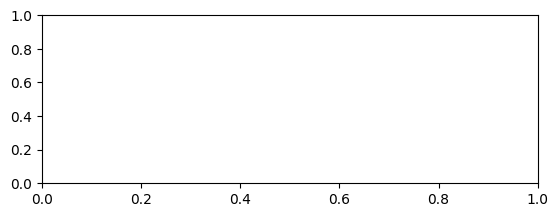

In [27]:
# 畫圖
# 前面先用list將要畫的變數存起來

x1 = range(0, epochs)
x2 = range(0, epochs)

y1 = valid_Accuracy_list
y2 = train_Loss_list
y3 = valid_Loss_list
y4 = train_Accuracy_list

plt.subplot(2, 1, 1) #subplot(numRows, numCols, plotNum)

plt.plot(x1, y4, color='#9932cc', linestyle='-')
plt.plot(x1, y1, color='#1e90ff', linestyle='-') #The o will produce a small circle. The - will produce a solid line to connect the markers.
plt.title('accuracy vs. epoches')
plt.ylabel('accuracy')
plt.legend(('training', 'validation'), loc = 4)
# plt.ylim(0.8,1)

plt.subplot(2, 1, 2)
plt.plot(x2, y2, color='#008080', linestyle='-')
plt.plot(x2, y3, color='#d2691e', linestyle='-')

plt.ylim(0.0, 1) # y 範圍


plt.legend(('training', 'validation'))
plt.xlabel('loss vs. epoches')
plt.ylabel('loss')

plt.show()
plt.savefig("accuracy_loss.jpg")

## Prediction

In [28]:
def inference(x_data):
    PATH = 'model_CNN.pth' # 儲存模型的路徑
    # 載入模型
    model = Class2().to('cpu') # 實例化我們的PyTorch模型
    model.load_state_dict(torch.load(PATH)) # 載入已儲存的模型
    #summary(model, (1, 64, 64), device='cpu') # 檢查是否一切都正確
    

    dataiter = iter(x_data) # 獲取整个批次
    images= next(dataiter) # 提取圖像
   

    # 圖像需要一些處理！
    #image = images[0] # 從批次中取第一張圖像 = 1 x 64 x 64
    # 隨機選擇一張影像進行推斷
    # 記住，我們的模型期望第一個維度作為'批大小'
    # 因此，在'開始'添加一個額外的維度。
    image = torch.unsqueeze(images, dim=0) # 1 x 1 x 64 x 64 (批大小 = 1)
    print('\nimage.shape =>', image.shape)

    # 停用自動微分模組
    with torch.no_grad(): # 不需要計算梯度，因為我們不在訓練
        image = image.to('cpu')
        # 進行前向傳播
        output = model.forward(image)
        
    # 將 output 移到 CPU 上
    output_cpu = output.cpu()

    # 模型輸出'logits'，將其轉換為類別機率。 (使用 'Softmax' 函式 )
   
    class_probabilities = F.softmax(output, dim=1).numpy().squeeze()
    print('\n類別機率 ==>', class_probabilities)
    for i, proba in enumerate(class_probabilities):
        print(f'類别 \t{i}\t 機率 \t{100*proba:.2f}%')


    # 建立一個具有兩個座標軸的圖，ax1和ax2
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2) # 有2列的子圖
    # ax1 顯示來自資料集的圖像
    ax1.imshow(image.resize_(1, 64, 64).numpy().squeeze())  #
    ax1.set_title('LABER' + str(labels[0].to('cpu').numpy()))
    # ax2 包含類別機率的水平長條圖
    ax2.barh(np.arange(2), class_probabilities)
    ax2.set_aspect(0.1) # 調整ax2的縱橫比，否則它會變得太大
    ax2.set_yticks(np.arange(2)) # 10個類別的y軸上有10個刻度
    ax2.set_yticklabels(np.arange(2)) # 設定刻度標籤從0到9
    ax2.set_title('CLASS')
    ax2.set_xlim(0, 1.1) # 機率不能超過1，因此將限制設為1.1
    

    return None


In [29]:
inference(x_data)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [30]:
model(x_data)

tensor([[0.4494, 0.5506],
        [0.4469, 0.5531],
        [0.4513, 0.5487],
        [0.4496, 0.5504],
        [0.4491, 0.5509],
        [0.4492, 0.5508],
        [0.4568, 0.5432],
        [0.4491, 0.5509],
        [0.4459, 0.5541],
        [0.4473, 0.5527],
        [0.4488, 0.5512],
        [0.4447, 0.5553],
        [0.4576, 0.5424],
        [0.4384, 0.5616],
        [0.4473, 0.5527],
        [0.4453, 0.5547],
        [0.4525, 0.5475],
        [0.4499, 0.5501],
        [0.4472, 0.5528],
        [0.4521, 0.5479],
        [0.4424, 0.5576],
        [0.4501, 0.5499],
        [0.4445, 0.5555],
        [0.4455, 0.5545],
        [0.4462, 0.5538],
        [0.4513, 0.5487],
        [0.4459, 0.5541],
        [0.4449, 0.5551],
        [0.4522, 0.5478],
        [0.4494, 0.5506],
        [0.4512, 0.5488],
        [0.4475, 0.5525],
        [0.4516, 0.5484],
        [0.4487, 0.5513],
        [0.4487, 0.5513],
        [0.4489, 0.5511],
        [0.4468, 0.5532],
        [0.4564, 0.5436],
        [0.4


grad_fn是一個函數“句柄”，可以存取適用的梯度函數。給定點的梯度是反向傳播時調整權重的係數。